In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

# READING DATA

In [2]:
dft = pd.read_csv('train_data.csv')
dfr = pd.read_csv('resources.csv')

In [3]:
print("Number of data points in train data", dft.shape)
print('-'*50)
print("The attributes of data :", dft.columns.values)

Number of data points in train data (109248, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [4]:
print("Number of data points in train data", dfr.shape)
print(dfr.columns.values)
dfr.head(2)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95


In [5]:
# how to replace elements in list python: https://stackoverflow.com/a/2582163/4084039
cols = ['Date' if x=='project_submitted_datetime' else x for x in list(dft.columns)]


#sort dataframe based on time pandas python: https://stackoverflow.com/a/49702492/4084039
dft['Date'] = pd.to_datetime(dft['project_submitted_datetime'])
dft.drop('project_submitted_datetime', axis=1, inplace=True)
dft.sort_values(by=['Date'], inplace=True)


# how to reorder columns pandas python: https://stackoverflow.com/a/13148611/4084039
dft = dft[cols]


dft.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,Date,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
55660,8393,p205479,2bf07ba08945e5d8b2a3f269b2b3cfe5,Mrs.,CA,2016-04-27 00:27:36,Grades PreK-2,Math & Science,"Applied Sciences, Health & Life Science",Engineering STEAM into the Primary Classroom,I have been fortunate enough to use the Fairy ...,My students come from a variety of backgrounds...,Each month I try to do several science or STEM...,It is challenging to develop high quality scie...,My students need STEM kits to learn critical s...,53,1
76127,37728,p043609,3f60494c61921b3b43ab61bdde2904df,Ms.,UT,2016-04-27 00:31:25,Grades 3-5,Special Needs,Special Needs,Sensory Tools for Focus,Imagine being 8-9 years old. You're in your th...,"Most of my students have autism, anxiety, anot...",It is tough to do more than one thing at a tim...,When my students are able to calm themselves d...,My students need Boogie Boards for quiet senso...,4,1


# TEXT PROCESSING

In [6]:
# merge two column text dataframe: 
dft["essay"] = dft["project_essay_1"].map(str) +\
                        dft["project_essay_2"].map(str) + \
                        dft["project_essay_3"].map(str) + \
                        dft["project_essay_4"].map(str)

In [7]:
dft.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,Date,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,essay
55660,8393,p205479,2bf07ba08945e5d8b2a3f269b2b3cfe5,Mrs.,CA,2016-04-27 00:27:36,Grades PreK-2,Math & Science,"Applied Sciences, Health & Life Science",Engineering STEAM into the Primary Classroom,I have been fortunate enough to use the Fairy ...,My students come from a variety of backgrounds...,Each month I try to do several science or STEM...,It is challenging to develop high quality scie...,My students need STEM kits to learn critical s...,53,1,I have been fortunate enough to use the Fairy ...
76127,37728,p043609,3f60494c61921b3b43ab61bdde2904df,Ms.,UT,2016-04-27 00:31:25,Grades 3-5,Special Needs,Special Needs,Sensory Tools for Focus,Imagine being 8-9 years old. You're in your th...,"Most of my students have autism, anxiety, anot...",It is tough to do more than one thing at a tim...,When my students are able to calm themselves d...,My students need Boogie Boards for quiet senso...,4,1,Imagine being 8-9 years old. You're in your th...


In [8]:
# https://stackoverflow.com/a/47091490/4084039
import re
def decontracted(phrase):
# specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
# general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


In [9]:
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

# Preprocessing of project_subject_categories

In [10]:
catogories = list(dft['project_subject_categories'].values)

cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
dft['clean_categories'] = cat_list
dft.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in dft['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))

# Preprocessing of project_subject_subcategories

In [11]:
sub_catogories = list(dft['project_subject_subcategories'].values)
# remove special characters from list of strings python:
#https://stackoverflow.com/a/47301924/4084039

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

dft['clean_subcategories'] = sub_cat_list
dft.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: 
#https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in dft['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

In [12]:
# we have to remove the grades from every row
print(dft['project_grade_category'][:20])

55660     Grades PreK-2
76127        Grades 3-5
51140     Grades PreK-2
473       Grades PreK-2
41558        Grades 3-5
29891        Grades 3-5
81565        Grades 3-5
79026        Grades 3-5
23374     Grades PreK-2
86551        Grades 3-5
49228     Grades PreK-2
72638       Grades 9-12
7176      Grades PreK-2
70898        Grades 3-5
102755       Grades 3-5
72593     Grades PreK-2
35006        Grades 3-5
100222       Grades 3-5
5145         Grades 3-5
48237       Grades 9-12
Name: project_grade_category, dtype: object


In [13]:
d= list(dft['project_grade_category'].values)
# remove special characters from list of strings python:
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/

grade_cat_list = []
for i in d:
# consider we have text like this:
    for j in i.split(' '): # # split by space
        j=j.replace('Grades','')# clean grades from the row
    grade_cat_list.append(j.strip())
    
dft['clean_grade'] = grade_cat_list
dft.drop(['project_grade_category'], axis=1, inplace=True)

my_counter = Counter()
for word in dft['clean_grade'].values:
     my_counter.update(word.split())
project_grade_category_dict= dict(my_counter)
sorted_project_grade_category_dict = dict(sorted(project_grade_category_dict.items(), key=lambda kv: kv[1]))

# Preparing data for the models

# Test - Train Split

In [14]:
# train test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dft, dft['project_is_approved'],stratify = dft['project_is_approved'], test_size=0.33)
X_train,X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

In [15]:
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, stratify= y_train,test_size = 0.33)

In [16]:
print(y_train.value_counts())
print(y_test.value_counts())
print(y_cv.value_counts())

1    27882
0     4975
Name: project_is_approved, dtype: int64
1    30593
0     5459
Name: project_is_approved, dtype: int64
1    13733
0     2451
Name: project_is_approved, dtype: int64


In [17]:
#droping the y labels
#https://stackoverflow.com/questions/13411544/delete-column-from-pandas-dataframe-by-column-name

X_train.drop(["project_is_approved"], axis = 1, inplace = True)

X_test.drop(["project_is_approved"], axis = 1, inplace = True)

X_cv.drop(["project_is_approved"], axis = 1, inplace = True)


# Text preprocessing


In [18]:
#Proprocessing for essay
# Combining all the above students
from tqdm import tqdm
preprocessed_essays_train = []
# tqdm is for printing the status bar
for sentance in tqdm(X_train['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
# https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays_train.append(sent.lower().strip())


100%|██████████████████████████████████████████████████████████████████████████| 32857/32857 [00:26<00:00, 1258.45it/s]


In [19]:
#Proprocessing for essay
# Combining all the above students
from tqdm import tqdm
preprocessed_essays_test = []
# tqdm is for printing the status bar
for sentance in tqdm(X_test['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
# https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays_test.append(sent.lower().strip())

100%|██████████████████████████████████████████████████████████████████████████| 36052/36052 [00:25<00:00, 1440.69it/s]


In [20]:
#Proprocessing for essay
# Combining all the above students
from tqdm import tqdm
preprocessed_essays_cv = []
# tqdm is for printing the status bar
for sentance in tqdm(X_cv['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
# https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays_cv.append(sent.lower().strip())


100%|██████████████████████████████████████████████████████████████████████████| 16184/16184 [00:11<00:00, 1460.60it/s]


In [21]:
#Proprocessing for essay
# Combining all the above students
from tqdm import tqdm
preprocessed_titles_cv = []
# tqdm is for printing the status bar
for sentance in tqdm(X_cv['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
# https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_titles_cv.append(sent.lower().strip())

100%|█████████████████████████████████████████████████████████████████████████| 16184/16184 [00:00<00:00, 27834.18it/s]


In [22]:
#Proprocessing for essay
# Combining all the above students
from tqdm import tqdm
preprocessed_titles_train = []
# tqdm is for printing the status bar
for sentance in tqdm(X_train['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
# https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_titles_train.append(sent.lower().strip())


100%|█████████████████████████████████████████████████████████████████████████| 32857/32857 [00:01<00:00, 28351.90it/s]


In [23]:
#Proprocessing for essay
# Combining all the above students
from tqdm import tqdm
preprocessed_titles_test = []
# tqdm is for printing the status bar
for sentance in tqdm(X_test['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
# https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_titles_test.append(sent.lower().strip())

100%|█████████████████████████████████████████████████████████████████████████| 36052/36052 [00:01<00:00, 28872.58it/s]


# Encoding numerical, Categorical features

# vectorize categorical data

In [24]:
#project_subject_categories convert categorical to vectors

# convert train,cv and test data of clean_categories into vectors
# we use count vectorizer to convert the values into one
from sklearn.feature_extraction.text import CountVectorizer
vectorizer1 = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False,binary=True)
vectorizer1.fit(X_train['clean_categories'].values)
# firstly convert fit the train data into the vectoriaer then it learn hte vocablery
# we use the fitted CountVectorizer to convert the text to vector
X_train_cat = vectorizer1.transform(X_train['clean_categories'].values)
X_cv_cat = vectorizer1.transform(X_cv['clean_categories'].values)
X_test_cat = vectorizer1.transform(X_test['clean_categories'].values)
print(vectorizer1.get_feature_names())


['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']


In [25]:
print("After vectorizations")
print(X_train_cat.shape, y_train.shape)
print(X_cv_cat.shape, y_cv.shape)
print(X_test_cat.shape, y_test.shape)
print("="*100)


After vectorizations
(32857, 9) (32857,)
(16184, 9) (16184,)
(36052, 9) (36052,)


In [26]:
##project_subject_subcategories convert categorical to vectors
# convert train,cv and test data of clean_categories into vectors
# we use count vectorizer to convert the values into one
from sklearn.feature_extraction.text import CountVectorizer
vectorizer2 = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)
vectorizer2.fit(X_train['clean_subcategories'].values)
# firstly convert fit the train data into the vectoriaer then it learn hte vocablery
# we use the fitted CountVectorizer to convert the text to vector
X_train_subcat = vectorizer2.transform(X_train['clean_subcategories'].values)
X_cv_subcat = vectorizer2.transform(X_cv['clean_subcategories'].values)
X_test_subcat = vectorizer2.transform(X_test['clean_subcategories'].values)
print(vectorizer2.get_feature_names())

['Economics', 'CommunityService', 'FinancialLiteracy', 'ParentInvolvement', 'Extracurricular', 'Civics_Government', 'ForeignLanguages', 'NutritionEducation', 'Warmth', 'Care_Hunger', 'SocialSciences', 'PerformingArts', 'CharacterEducation', 'TeamSports', 'Other', 'College_CareerPrep', 'Music', 'History_Geography', 'Health_LifeScience', 'EarlyDevelopment', 'ESL', 'Gym_Fitness', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']


In [27]:
print("After vectorizations")
print(X_train_subcat.shape, y_train.shape)
print(X_cv_subcat.shape, y_cv.shape)
print(X_test_subcat.shape, y_test.shape)
print("="*100)

After vectorizations
(32857, 30) (32857,)
(16184, 30) (16184,)
(36052, 30) (36052,)


In [28]:
# school_state convert categorical to vectors
# now time to cont the each words
from collections import Counter
my_counter = Counter()
for word in dft['school_state'].values:
    my_counter.update(word.split())# count the words
school_state_dict = dict(my_counter)# store in dicionary
sorted_school_state_dict = dict(sorted(school_state_dict.items(), key=lambda kv: kv[1]))
print(sorted_school_state_dict)

{'VT': 80, 'WY': 98, 'ND': 143, 'MT': 245, 'RI': 285, 'SD': 300, 'NE': 309, 'DE': 343, 'AK': 345, 'NH': 348, 'WV': 503, 'ME': 505, 'HI': 507, 'DC': 516, 'NM': 557, 'KS': 634, 'IA': 666, 'ID': 693, 'AR': 1049, 'CO': 1111, 'MN': 1208, 'OR': 1242, 'KY': 1304, 'MS': 1323, 'NV': 1367, 'MD': 1514, 'CT': 1663, 'TN': 1688, 'UT': 1731, 'AL': 1762, 'WI': 1827, 'VA': 2045, 'AZ': 2147, 'NJ': 2237, 'OK': 2276, 'WA': 2334, 'MA': 2389, 'LA': 2394, 'OH': 2467, 'MO': 2576, 'IN': 2620, 'PA': 3109, 'MI': 3161, 'SC': 3936, 'GA': 3963, 'IL': 4350, 'NC': 5091, 'FL': 6185, 'NY': 7318, 'TX': 7396, 'CA': 15388}


In [29]:
# convert train,cv and test data of clean_categories into vectors
# we use count vectorizer to convert the values into one
from sklearn.feature_extraction.text import CountVectorizer
vectorizer3 = CountVectorizer(vocabulary=list(sorted_school_state_dict.keys()), lowercase=False, binary=True)
vectorizer3.fit(dft['school_state'].values)
# firstly convert fit the train data into the vector then it learn the vocablery
# we use the fitted CountVectorizer to convert the text to vector
X_train_school_state = vectorizer3.transform(X_train['school_state'].values)
X_cv_school_state = vectorizer3.transform(X_cv['school_state'].values)
X_test_school_state = vectorizer3.transform(X_test['school_state'].values)
print(vectorizer3.get_feature_names())

['VT', 'WY', 'ND', 'MT', 'RI', 'SD', 'NE', 'DE', 'AK', 'NH', 'WV', 'ME', 'HI', 'DC', 'NM', 'KS', 'IA', 'ID', 'AR', 'CO', 'MN', 'OR', 'KY', 'MS', 'NV', 'MD', 'CT', 'TN', 'UT', 'AL', 'WI', 'VA', 'AZ', 'NJ', 'OK', 'WA', 'MA', 'LA', 'OH', 'MO', 'IN', 'PA', 'MI', 'SC', 'GA', 'IL', 'NC', 'FL', 'NY', 'TX', 'CA']


In [30]:
print("After vectorizations")
print(X_train_school_state .shape, y_train.shape)
print(X_cv_school_state .shape, y_cv.shape)
print(X_test_school_state .shape, y_test.shape)
print("="*100)

After vectorizations
(32857, 51) (32857,)
(16184, 51) (16184,)
(36052, 51) (36052,)


In [31]:
#project_grade_category categorical to vectors
#https://stackoverflow.com/questions/42224700/attributeerror-float-object-has-no-attribute-split
dft['clean_grade']=dft['clean_grade'].fillna("")# fill the null values with space
# convert train,cv and test data of clean_categories into vectors
# we use count vectorizer to convert the values into one
from sklearn.feature_extraction.text import CountVectorizer
vectorizer4 = CountVectorizer(vocabulary=list(sorted_project_grade_category_dict.keys()),lowercase=False, binary=True)
vectorizer4.fit(dft['clean_grade'].values)
# firstly convert fit the train data into the vectoriaer then it learn hte vocablery
# we use the fitted CountVectorizer to convert the text to vector
X_train_project_grade_category = vectorizer4.transform(X_train['clean_grade'].values)
X_cv_project_grade_category = vectorizer4.transform(X_cv['clean_grade'].values)
X_test_project_grade_category = vectorizer4.transform(X_test['clean_grade'].values)
print(vectorizer4.get_feature_names())

['9-12', '6-8', '3-5', 'PreK-2']


In [32]:
print("After vectorizations")
print(X_train_project_grade_category .shape, y_train.shape)
print(X_cv_project_grade_category .shape, y_cv.shape)
print(X_test_project_grade_category .shape, y_test.shape)
print("="*100)

After vectorizations
(32857, 4) (32857,)
(16184, 4) (16184,)
(36052, 4) (36052,)


In [33]:
#teacher_prefix categorical to vectors
#https://stackoverflow.com/questions/42224700/attributeerror-float-object-has-no-attribute-split
dft['teacher_prefix']=dft['teacher_prefix'].fillna(" ")# filll the null valueswith space
my_counter = Counter()
for word in dft['teacher_prefix'].values:
    my_counter.update(word.split())
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
teacher_cat_dict = dict(my_counter)
sorted_teacher_prefix_dict = dict(sorted(teacher_cat_dict.items(), key=lambda kv: kv[1]))

In [34]:
# convert train,cv and test data of clean_categories into vectors
# we use count vectorizer to convert the values into one
from sklearn.feature_extraction.text import CountVectorizer
vectorizer5 = CountVectorizer(vocabulary=list(sorted_teacher_prefix_dict.keys()), lowercase=False,binary=True)
vectorizer5.fit(dft['teacher_prefix'].values.astype('U'))
# firstly convert fit the train data into the vectorizer 
# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_prefix = vectorizer5.transform(X_train['teacher_prefix'].values.astype('U'))
X_cv_teacher_prefix= vectorizer5.transform(X_cv['teacher_prefix'].values.astype('U'))
X_test_teacher_prefix = vectorizer5.transform(X_test['teacher_prefix'].values.astype('U'))
print(vectorizer5.get_feature_names())

['Dr.', 'Teacher', 'Mr.', 'Ms.', 'Mrs.']


In [35]:
print("After vectorizations")
print(X_train_teacher_prefix .shape, y_train.shape)
print(X_cv_teacher_prefix .shape, y_cv.shape)
print(X_test_teacher_prefix .shape, y_test.shape)
print("="*100)

After vectorizations
(32857, 5) (32857,)
(16184, 5) (16184,)
(36052, 5) (36052,)


# Encoding essay, and Project_title

In [36]:
#bow featurization essay

X_train_essay=preprocessed_essays_train
X_cv_essay=preprocessed_essays_cv
X_test_essay=preprocessed_essays_test

X_train_title=preprocessed_titles_train
X_cv_title=preprocessed_titles_cv
X_test_title=preprocessed_titles_test
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer6 = CountVectorizer(min_df=10,max_features=5000,ngram_range=(1, 2))
vectorizer6.fit(X_train_essay)# that is learned from trained data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer6.transform(X_train_essay)
X_cv_bow = vectorizer6.transform(X_cv_essay)
X_test_bow = vectorizer6.transform(X_test_essay)


In [37]:
#bow featurization title
vectorizer7 = CountVectorizer(min_df=10,max_features=5000,ngram_range=(1, 2))
vectorizer7.fit(X_train_title)# that is learned from trainned data
# we use the fitted CountVectorizer to convert the text to vector
X_train_bow_title = vectorizer7.transform(X_train_title)
X_cv_bow_title= vectorizer7.transform(X_cv_title)
X_test_bow_title = vectorizer7.transform(X_test_title)
print("After vectorizations")
print(X_train_bow_title.shape, y_train.shape)
print(X_cv_bow_title.shape, y_cv.shape)
print(X_test_bow_title.shape, y_test.shape)
print("="*100)


After vectorizations
(32857, 2288) (32857,)
(16184, 2288) (16184,)
(36052, 2288) (36052,)


# Tfidf featurization

In [38]:
#for titles
from sklearn.feature_extraction.text import TfidfVectorizer
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer8 = TfidfVectorizer(min_df=10,max_features=5000,ngram_range=(1, 2))
vectorizer8.fit(X_train_title)# that is learned from trained data

# we use the fitted CountVectorizer to convert the text to vector
X_train_tf_title = vectorizer8.transform(X_train_title)
X_cv_tf_title= vectorizer8.transform(X_cv_title)
X_test_tf_title = vectorizer8.transform(X_test_title)
print("After vectorizations")
print(X_train_tf_title.shape, y_train.shape)
print(X_cv_tf_title.shape, y_cv.shape)
print(X_test_tf_title.shape, y_test.shape)
print("="*100)


After vectorizations
(32857, 2288) (32857,)
(16184, 2288) (16184,)
(36052, 2288) (36052,)


In [39]:
#for essay
from sklearn.feature_extraction.text import TfidfVectorizer
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer9 = TfidfVectorizer(min_df=10,max_features=5000,ngram_range=(1, 2))
vectorizer9.fit(X_train_essay)# that is learned from trained data
# we use the fitted CountVectorizer to convert the text to vector
X_train_tf_essay = vectorizer9.transform(X_train_essay)
X_cv_tf_essay= vectorizer9.transform(X_cv_essay)
X_test_tf_essay = vectorizer9.transform(X_test_essay)
print("After vectorizations")
print(X_train_tf_essay.shape, y_train.shape)
print(X_cv_tf_essay.shape, y_cv.shape)
print(X_test_tf_essay.shape, y_test.shape)
print("="*100)

After vectorizations
(32857, 5000) (32857,)
(16184, 5000) (16184,)
(36052, 5000) (36052,)


# Using Pretrained Models : AVG W2V

In [40]:
# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039

def loadGloveModel(gloveFile):
    
    print ("Loading Glove Model")
    
    f = open(gloveFile,'r', encoding = 'utf8')
    
    model = {}
    
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    
    print ("Done.",len(model)," words loaded!")
    
    return model


In [41]:
 model = loadGloveModel('glove.42B.300d.txt')

Loading Glove Model


1917495it [04:53, 6540.17it/s]


Done. 1917495  words loaded!


In [42]:
glove_words = set(model.keys()) 

In [43]:
#for essay
# average Word2Vec
# compute average word2vec for each review.
def func(wordlist):
    
  train_avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
  for sentence in tqdm(wordlist): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length # we are taking the 300dimensions very large
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    train_avg_w2v_vectors.append(vector)
    
  print(len(train_avg_w2v_vectors))
  print(len(train_avg_w2v_vectors[0]))
  return train_avg_w2v_vectors

In [44]:
train_avg_w2v_vectors=func(preprocessed_essays_train)
test_avg_w2v_vectors=func(preprocessed_essays_test)
cv_avg_w2v_vectors=func(preprocessed_essays_cv)
#for titles
cv_avg_w2v_vectors_title=func(preprocessed_titles_cv)
test_avg_w2v_vectors_title=func(preprocessed_titles_test)
train_avg_w2v_vectors_title=func(preprocessed_titles_train)

100%|██████████████████████████████████████████████████████████████████████████| 32857/32857 [00:11<00:00, 2840.08it/s]


32857
300


100%|██████████████████████████████████████████████████████████████████████████| 36052/36052 [00:11<00:00, 3026.24it/s]


36052
300


100%|██████████████████████████████████████████████████████████████████████████| 16184/16184 [00:05<00:00, 3024.66it/s]


16184
300


100%|█████████████████████████████████████████████████████████████████████████| 16184/16184 [00:00<00:00, 50869.31it/s]


16184
300


100%|█████████████████████████████████████████████████████████████████████████| 36052/36052 [00:00<00:00, 52694.52it/s]


36052
300


100%|█████████████████████████████████████████████████████████████████████████| 32857/32857 [00:00<00:00, 57395.30it/s]


32857
300


# Using Pretrained Models: TFIDF weighted W2V

In [45]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_essays_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [46]:
# average Word2Vec
# compute average word2vec for each review.
def tf_idf_done(word_list):
    train_title_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(word_list): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split():#.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
              #vec = model.wv[word]  
              vec = model[word] # getting the vector for each word
# here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
              tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) 
              vector += (vec * tf_idf) # calculating tfidf weighted w2v
              tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        train_title_tfidf_w2v_vectors.append(vector)
    print(len(train_title_tfidf_w2v_vectors))
    print(len(train_title_tfidf_w2v_vectors[0]))
    return train_title_tfidf_w2v_vectors


In [47]:
#train_title_tfidf_w2v_vectors=tf_idf_done(tf_idf_train_title)
#train_title_tfidf_w2v_vector
train_tfidf_w2v_vectors=tf_idf_done(preprocessed_essays_train)
test_tfidf_w2v_vectors=tf_idf_done(preprocessed_essays_test)
cv_tfidf_w2v_vectors=tf_idf_done(preprocessed_essays_cv)


100%|███████████████████████████████████████████████████████████████████████████| 32857/32857 [00:53<00:00, 614.74it/s]


32857
300


100%|███████████████████████████████████████████████████████████████████████████| 36052/36052 [00:58<00:00, 613.16it/s]


36052
300


100%|███████████████████████████████████████████████████████████████████████████| 16184/16184 [00:26<00:00, 609.49it/s]


16184
300


In [48]:
#train_title_tfidf_w2v_vectors=tf_idf_done(tf_idf_train_title)
#train_title_tfidf_w2v_vector
train_title_tfidf_w2v_vectors=tf_idf_done(preprocessed_titles_train)
test_title_tfidf_w2v_vectors=tf_idf_done(preprocessed_titles_test)
cv_title_tfidf_w2v_vectors=tf_idf_done(preprocessed_titles_cv)

100%|█████████████████████████████████████████████████████████████████████████| 32857/32857 [00:00<00:00, 38575.71it/s]


32857
300


100%|█████████████████████████████████████████████████████████████████████████| 36052/36052 [00:00<00:00, 41274.61it/s]


36052
300


100%|█████████████████████████████████████████████████████████████████████████| 16184/16184 [00:00<00:00, 36548.17it/s]


16184
300


# Vectorizing Numerical features

In [49]:
price_data = dfr.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
dft = pd.merge(dft, price_data, on='id', how='left')
print(price_data.head(2))
# we also have to do this in tran,test and cv
# so also merge the resource data with the trian,cv and test
X_train = pd.merge(X_train, price_data, on = "id", how = "left")
#print(x_train.columns)
X_test = pd.merge(X_test, price_data, on = "id", how = "left")
X_cv = pd.merge(X_cv, price_data, on = "id", how = "left")

        id   price  quantity
0  p000001  459.56         7
1  p000002  515.89        21


In [50]:
#standardization
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# standardization sklearn: https://scikitlearn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing


price_scalar = StandardScaler()
price_scalar.fit(X_train['price'].values.reshape(-1,1)) # finding the mean and standard deviationof this data
#print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")
# Now standardize the data with above mean and variance.
train_price_standar = price_scalar.transform(X_train['price'].values.reshape(-1, 1))
# Now standardize the data with above maen and variance.
test_price_standar = price_scalar.transform(X_test['price'].values.reshape(-1, 1))
# Now standardize the data with above maen and variance.
cv_price_standar = price_scalar.transform(X_cv['price'].values.reshape(-1, 1))

In [51]:
# previous_year_projects
price_scalar.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
#print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")
# Now standardize the data with above maen and variance.
train_prev_proj_standar =price_scalar.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
# Now standardize the data with above maen and variance.
test_prev_proj_standar =price_scalar.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
# Now standardize the data with above maen and variance.
cv_prev_proj_standar = price_scalar.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))


In [52]:
price_scalar.fit(X_train['quantity'].values.reshape(-1,1)) # finding the mean and standarddeviation of this data
#print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")
# Now standardize the data with above maen and variance.
train_qnty_standar = price_scalar.transform(X_train['quantity'].values.reshape(-1, 1))
# Now standardize the data with above maen and variance.
cv_qnty_standar = price_scalar.transform(X_cv['quantity'].values.reshape(-1, 1))
# Now standardize the data with above maen and variance.
test_qnty_standar = price_scalar.transform(X_test['quantity'].values.reshape(-1, 1))

# merging


In [53]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx
X_set1_train = hstack((X_train_bow_title,X_train_bow,# all bows
                       X_train_teacher_prefix,X_train_cat,X_train_subcat
                      ,X_train_project_grade_category,X_train_school_state,
                       train_qnty_standar,train_price_standar,train_prev_proj_standar))
print(X_set1_train.shape, y_train.shape)

(32857, 7390) (32857,)


In [54]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx
X_set1_cv = hstack((X_cv_bow_title,X_cv_bow,
                    X_cv_teacher_prefix,X_cv_cat,X_cv_subcat,
                    X_cv_project_grade_category,X_cv_school_state,
                    cv_qnty_standar,cv_price_standar,cv_prev_proj_standar))
print(X_set1_cv.shape, y_cv.shape)

(16184, 7390) (16184,)


In [55]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx 
X_set1_test = hstack((X_test_bow_title,X_test_bow,
                      X_test_teacher_prefix,X_test_cat,X_test_subcat,
                      X_test_project_grade_category,X_test_school_state,
                      test_qnty_standar,test_price_standar,test_prev_proj_standar))
print(X_set1_test.shape, y_test.shape)

(36052, 7390) (36052,)


In [56]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx 
X_set2_train = hstack((X_train_tf_essay,X_train_tf_title,
                       X_train_teacher_prefix,X_train_cat,X_train_subcat,
                       X_train_project_grade_category,X_train_school_state,
                       train_qnty_standar,train_price_standar,train_prev_proj_standar))
print(X_set2_train.shape, y_train.shape)

(32857, 7390) (32857,)


In [57]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx
X_set2_cv = hstack((X_cv_tf_essay,X_cv_tf_title,
                    X_cv_teacher_prefix,X_cv_cat,X_cv_subcat,
                    X_cv_project_grade_category,X_cv_school_state,
                    cv_qnty_standar,cv_price_standar,cv_prev_proj_standar))
print(X_set2_cv.shape, y_cv.shape)

(16184, 7390) (16184,)


In [58]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx 
X_set2_test = hstack((X_test_tf_essay,X_test_tf_title,
                      X_test_teacher_prefix,X_test_cat,X_test_subcat,
                      X_test_project_grade_category,X_test_school_state,
                      test_qnty_standar,test_price_standar,test_prev_proj_standar))
print(X_set2_test.shape, y_test.shape)


(36052, 7390) (36052,)


In [59]:
import numpy
s=numpy.array(train_avg_w2v_vectors)
print(X_train_project_grade_category.shape)
print(s.shape)

(32857, 4)
(32857, 300)


In [60]:
from scipy.sparse import hstack
import numpy
# with the same hstack function we are concatinating a sparse matrix and a dense matirx 
X_set3_train = hstack((numpy.array(train_avg_w2v_vectors),numpy.array(train_avg_w2v_vectors_title),train_prev_proj_standar,train_price_standar,train_qnty_standar,
                       X_train_teacher_prefix,X_train_cat,X_train_subcat,
                       X_train_project_grade_category,X_train_school_state))
print(X_set3_train.shape, y_train.shape)

(32857, 702) (32857,)


In [61]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx 
X_set3_cv =hstack((cv_avg_w2v_vectors,cv_avg_w2v_vectors_title,cv_prev_proj_standar,cv_price_standar,cv_qnty_standar,
                    X_cv_teacher_prefix,X_cv_cat,X_cv_subcat,
                    X_cv_project_grade_category,X_cv_school_state))
print(X_set3_cv.shape, y_cv.shape)

(16184, 702) (16184,)


In [62]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx 
X_set3_test =hstack((test_avg_w2v_vectors,test_avg_w2v_vectors_title,test_prev_proj_standar,test_price_standar,
                     test_qnty_standar,
                     X_test_teacher_prefix,X_test_cat,X_test_subcat,
                     X_test_project_grade_category,X_test_school_state))
print(X_set3_test.shape, y_test.shape)

(36052, 702) (36052,)


In [63]:
import numpy
s=numpy.array(train_tfidf_w2v_vectors)
print(X_train_project_grade_category.shape)
print(s.shape)


(32857, 4)
(32857, 300)


In [64]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx 
X_set4_train =hstack((train_tfidf_w2v_vectors, train_title_tfidf_w2v_vectors,train_prev_proj_standar,
                     train_price_standar,train_qnty_standar,
                      X_train_teacher_prefix,X_train_cat,X_train_subcat,
                      X_train_project_grade_category,X_train_school_state))

print(X_set4_train.shape, y_train.shape)

(32857, 702) (32857,)


In [65]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx 
X_set4_cv =hstack((cv_tfidf_w2v_vectors,cv_title_tfidf_w2v_vectors,cv_prev_proj_standar,
                   cv_price_standar,cv_qnty_standar,
                   X_cv_teacher_prefix,X_cv_cat,X_cv_subcat,
                   X_cv_project_grade_category,X_cv_school_state))


print(X_set4_cv.shape, y_cv.shape)


(16184, 702) (16184,)


In [66]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx 
X_set4_test = hstack((test_title_tfidf_w2v_vectors,test_tfidf_w2v_vectors,test_prev_proj_standar,test_price_standar,test_qnty_standar,X_test_teacher_prefix,X_test_cat,X_test_subcat,
                      X_test_project_grade_category,X_test_school_state))
print(X_set4_test.shape, y_test.shape)

(36052, 702) (36052,)


# Applying SVM on BOW

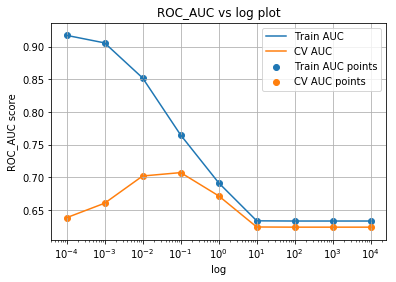

In [68]:
## By using "l2" Regulrizer
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
#from sklearn.datasets import *
from sklearn import linear_model
from sklearn.linear_model import SGDClassifier
from sklearn import svm
# hyperparameter tuning with l2 reg
parameters = {'alpha':[10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}
sd = SGDClassifier(loss = 'hinge', penalty = 'l2', class_weight = 'balanced')
classifier = GridSearchCV(sd, parameters, cv= 5, scoring='roc_auc',return_train_score=True)
classifier.fit(X_set1_train, y_train)

train_auc = classifier.cv_results_['mean_train_score']
cv_auc= classifier.cv_results_['mean_test_score']

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("log")
plt.xscale('log')
plt.ylabel("ROC_AUC score")
plt.title("ROC_AUC vs log plot")
plt.grid()
plt.show()


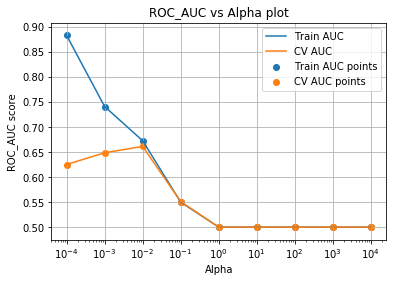

In [69]:
#By using  "l1" Regularization

# hyperparameter tuning with l1 reg
#parameters = {'alpha':[0.007,0.009,0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.2,1.4,1.6,1.8,2,2.2,2.4,2.6,2.8,3,3,3.5,4,4.5,5]}
import warnings
warnings.filterwarnings("ignore")

parameters = {'alpha':[10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}
sd = SGDClassifier(loss = 'hinge', penalty = 'l1', class_weight = 'balanced')
classifier = GridSearchCV(sd, parameters, cv= 5, scoring='roc_auc',return_train_score=True)
classifier.fit(X_set1_train, y_train)
train_auc = classifier.cv_results_['mean_train_score']
cv_auc= classifier.cv_results_['mean_test_score']

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
plt.plot(parameters['alpha'], cv_auc, label='CV AUC')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("Alpha")
plt.xscale('log')
plt.ylabel("ROC_AUC score")
plt.title("ROC_AUC vs Alpha plot")
plt.grid()
plt.show()

Observation:
l2 regularizatin works better than l1 and best alpha is 10.

# Fitting Model to Hyper-Parameter Curve

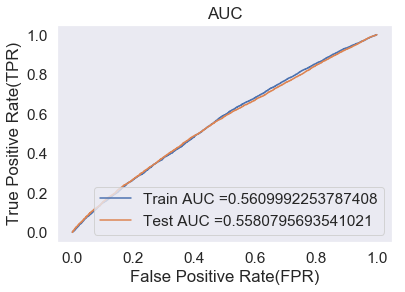

In [122]:
# https://scikitlearn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
Classifier_bow = SGDClassifier(loss = 'hinge', penalty = 'l2', alpha = 10)
Classifier_bow.fit(X_set1_train ,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positiveclass
#https://scikitlearn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier.decision_function
y_train_pred = Classifier_bow.decision_function(X_set1_train)
y_test_pred = Classifier_bow.decision_function(X_set1_test)
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.ylabel("True Positive Rate(TPR)")
plt.xlabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

In [73]:
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(fpr*(1-tpr))]
    print("the maximum value of tpr*(1-fpr)", np.round(max(tpr*(1-fpr)),2) , "for threshold", np.round(t,2))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions


the maximum value of tpr*(1-fpr) 0.25 for threshold 0.99


Text(0.5, 1.0, 'Test Confusion Matix')

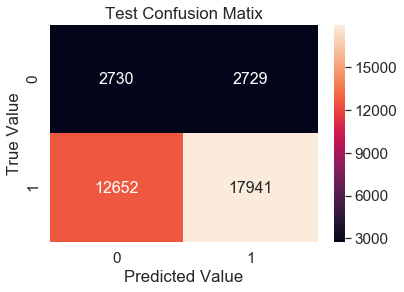

In [74]:
import seaborn as sea
test_confusion_matrix = pd.DataFrame(confusion_matrix(y_test,predict(y_test_pred, te_thresholds,test_fpr,test_fpr)),range(2),range(2))
sea.set(font_scale=1.4)
sea.heatmap(test_confusion_matrix, annot = True, annot_kws={"size":16}, fmt = 'd')
plt.xlabel("Predicted Value")
plt.ylabel("True Value")
plt.title("Test Confusion Matix")

the maximum value of tpr*(1-fpr) 0.25 for threshold 1.02


Text(0.5, 1.0, 'Train Confusion Matix')

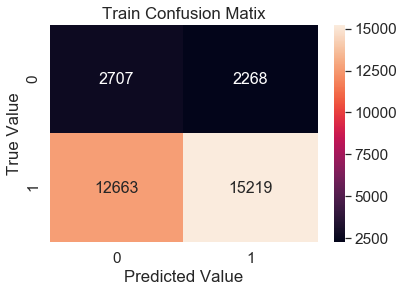

In [75]:
import seaborn as sea
train_confusion_matrix = pd.DataFrame(confusion_matrix(y_train,predict(y_train_pred, te_thresholds,train_fpr,train_fpr)),range(2),range(2))
sea.set(font_scale=1.4)
sea.heatmap(train_confusion_matrix, annot = True, annot_kws={"size":16}, fmt = 'd')
plt.xlabel("Predicted Value")
plt.ylabel("True Value")
plt.title("Train Confusion Matix")

# Applying SVM on TFIDF

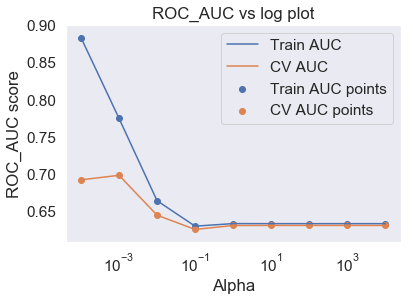

In [76]:
#BY USING L2 REGULARISER
# hyperparameter tuning with l2 reg
parameters = {'alpha':[10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}
sd = SGDClassifier(loss = 'hinge', penalty = 'l2', class_weight = 'balanced')
classifier = GridSearchCV(sd, parameters, cv= 5, scoring='roc_auc',return_train_score=True)
classifier.fit(X_set2_train, y_train)

train_auc = classifier.cv_results_['mean_train_score']
cv_auc= classifier.cv_results_['mean_test_score']

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')

plt.legend()
plt.xscale('log')
plt.xlabel("Alpha")
plt.ylabel("ROC_AUC score")
plt.title("ROC_AUC vs log plot")
plt.grid()
plt.show()

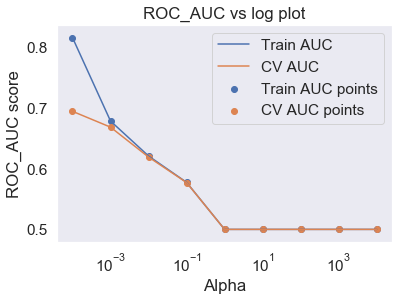

In [124]:
#BY USING "L1" REGULARISER
# hyperparameter tuning with l2 reg reduce the alpha values in list
parameters = {'alpha':[10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}
sd = SGDClassifier(loss = 'hinge', penalty = 'l1', class_weight = 'balanced')
classifier = GridSearchCV(sd, parameters, cv= 5, scoring='roc_auc',return_train_score=True)
classifier.fit(X_set2_train, y_train)
train_auc = classifier.cv_results_['mean_train_score']
cv_auc= classifier.cv_results_['mean_test_score']
plt.plot(parameters['alpha'], train_auc, label='Train AUC')
plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')
plt.legend()
plt.xscale('log')
plt.xlabel("Alpha")
plt.ylabel("ROC_AUC score")
plt.title("ROC_AUC vs log plot")
plt.grid()
plt.show()


In [ ]:
Observation:
l2 regularizatiOn works better than l1 and best alpha is 1.


# Fit the best hyperparameter

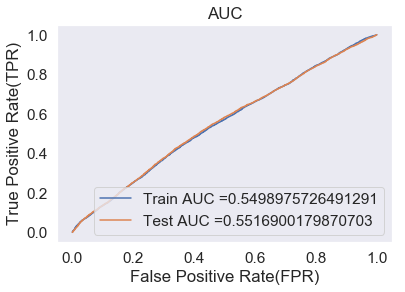

In [125]:
# https://scikitlearn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
Classifier_bow = SGDClassifier(loss = 'hinge', penalty = 'l2', alpha = 1)
Classifier_bow.fit(X_set2_train ,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positiveclass
#https://scikitlearn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier.decision_function
y_train_pred = Classifier_bow.decision_function(X_set2_train)
y_test_pred = Classifier_bow.decision_function(X_set2_test)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.ylabel("True Positive Rate(TPR)")
plt.xlabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

the maximum value of tpr*(1-fpr) 0.25 for threshold 0.53


Text(0.5, 1.0, 'Test Confusion Matix')

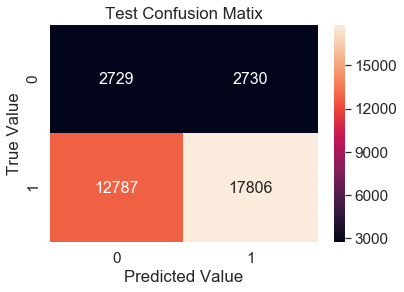

In [80]:
#CONFUSION MATRIX
import seaborn as sea
test_confusion_matrix = pd.DataFrame(confusion_matrix(y_test,predict(y_test_pred,te_thresholds,test_fpr,test_fpr)), range(2),range(2))
sea.set(font_scale=1.4)
sea.heatmap(test_confusion_matrix, annot = True, annot_kws={"size":16}, fmt = 'd')
plt.xlabel("Predicted Value")
plt.ylabel("True Value")
plt.title("Test Confusion Matix")


the maximum value of tpr*(1-fpr) 0.25 for threshold 0.57


Text(0.5, 1.0, 'Train Confusion Matix')

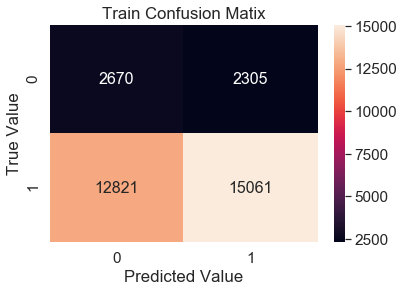

In [81]:
import seaborn as sea
train_confusion_matrix = pd.DataFrame(confusion_matrix(y_train,predict(y_train_pred,te_thresholds,train_fpr,train_fpr)), range(2),range(2))
sea.set(font_scale=1.4)
sea.heatmap(train_confusion_matrix, annot = True, annot_kws={"size":16}, fmt = 'd')
plt.xlabel("Predicted Value")
plt.ylabel("True Value")
plt.title("Train Confusion Matix")

# Applying SVM on AVG W2V

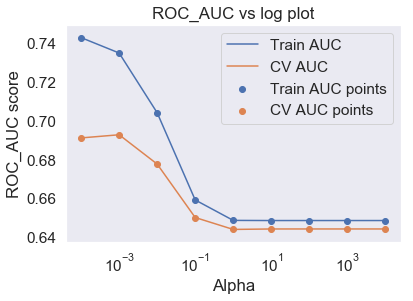

In [82]:
#BY USING "L2" REGULARISER
# hyperparameter tuning with l2 reg
parameters = {'alpha':[10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}
sd = SGDClassifier(loss = 'hinge', penalty = 'l2', class_weight = 'balanced')

classifier = GridSearchCV(sd, parameters, cv= 5, scoring='roc_auc',return_train_score=True)
classifier.fit(X_set3_train, y_train)

train_auc = classifier.cv_results_['mean_train_score']
cv_auc= classifier.cv_results_['mean_test_score']

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')
plt.legend()
plt.xscale('log')
plt.xlabel("Alpha")
plt.ylabel("ROC_AUC score")
plt.title("ROC_AUC vs log plot")
plt.grid()
plt.show()

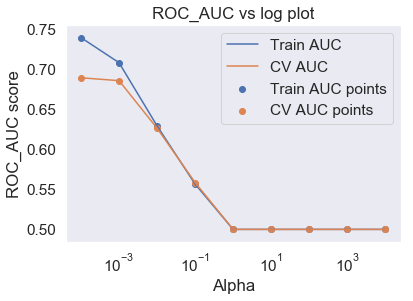

In [83]:
#BY USING "L1" REGULARISER
# hyperparameter tuning with l2 reg
parameters = {'alpha':[10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}
sd = SGDClassifier(loss = 'hinge', penalty = 'l1', class_weight = 'balanced')

classifier = GridSearchCV(sd, parameters, cv= 5, scoring='roc_auc',return_train_score=True)
classifier.fit(X_set3_train, y_train)

train_auc = classifier.cv_results_['mean_train_score']
cv_auc= classifier.cv_results_['mean_test_score']

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')
plt.legend()
plt.xscale('log')
plt.xlabel("Alpha")
plt.ylabel("ROC_AUC score")
plt.title("ROC_AUC vs log plot")
plt.grid()
plt.show()


Observation:
l2 regularizatiOn works better than l1 and best alpha is 1

# Fitting Model to Hyper-Parameter Curve:

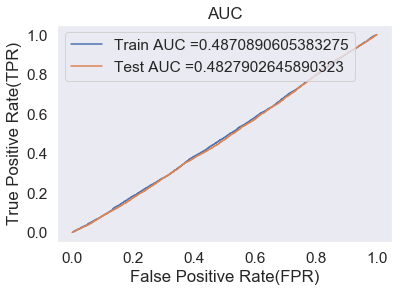

In [126]:
# https://scikitlearn.org/stable/modules/generated/sklearn.metrics.roc_curve

from sklearn.metrics import roc_curve, auc
Classifier_bow = SGDClassifier(loss = 'hinge', penalty = 'l2', alpha = 1)
Classifier_bow.fit(X_set3_train ,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positiveclass
#https://scikitlearn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier.decision_function
y_train_pred = Classifier_bow.decision_function(X_set3_train)
y_test_pred = Classifier_bow.decision_function(X_set3_test)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.ylabel("True Positive Rate(TPR)")
plt.xlabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()


the maximum value of tpr*(1-fpr) 0.25 for threshold 1.03


Text(0.5, 1.0, 'Test Confusion Matix')

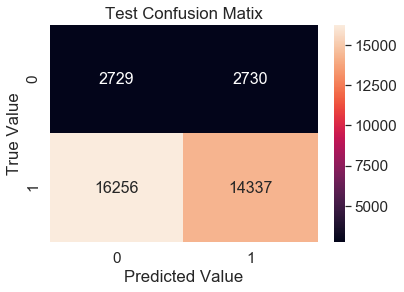

In [87]:
#CONFUSION MATRIX
import seaborn as sea
test_confusion_matrix = pd.DataFrame(confusion_matrix(y_test,predict(y_test_pred,te_thresholds,test_fpr,test_fpr)), range(2),range(2))
sea.set(font_scale=1.4)
sea.heatmap(test_confusion_matrix, annot = True, annot_kws={"size":16}, fmt = 'd')
plt.xlabel("Predicted Value")
plt.ylabel("True Value")
plt.title("Test Confusion Matix")

the maximum value of tpr*(1-fpr) 0.25 for threshold 1.04


Text(0.5, 1.0, 'Train Confusion Matix')

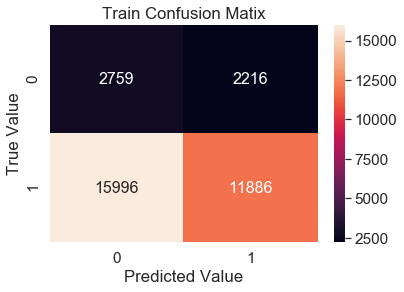

In [88]:
#CONFUSION MATRIX
train_confusion_matrix = pd.DataFrame(confusion_matrix(y_train,predict(y_train_pred,te_thresholds,train_fpr,train_fpr)), range(2),range(2))
sea.set(font_scale=1.4)
sea.heatmap(train_confusion_matrix, annot = True, annot_kws={"size":16}, fmt = 'd')
plt.xlabel("Predicted Value")
plt.ylabel("True Value")
plt.title("Train Confusion Matix")

# Applying SVM on td_idf W2V

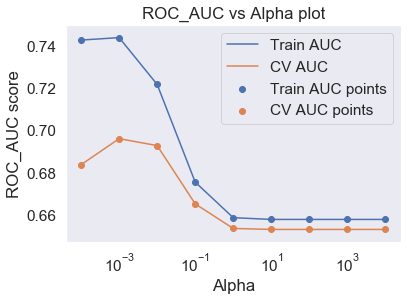

In [89]:
#BY USING "l2" REGULARISER

parameters = {'alpha':[10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}
SV = SGDClassifier(loss = 'hinge', penalty = 'l2', class_weight = 'balanced',)

classifier = GridSearchCV(SV, parameters, cv= 5, scoring='roc_auc',return_train_score=True)
classifier.fit(X_set4_train, y_train)

train_auc= classifier.cv_results_['mean_train_score']
cv_auc = classifier.cv_results_['mean_test_score']

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')
plt.legend()
plt.xscale('log')
plt.xlabel("Alpha")
plt.ylabel("ROC_AUC score")
plt.title("ROC_AUC vs Alpha plot")
plt.grid()
plt.show()

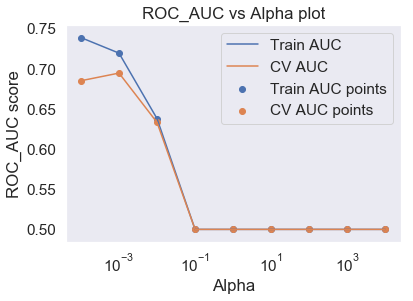

In [90]:
""#BY USING "L1" REGULARIZER

parameters = {'alpha':[10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}
SV = SGDClassifier(loss = 'hinge', penalty = 'l1', class_weight = 'balanced')

classifier = GridSearchCV(SV, parameters, cv= 5, scoring='roc_auc',return_train_score=True)
classifier.fit(X_set4_train, y_train)

train_auc= classifier.cv_results_['mean_train_score']
cv_auc = classifier.cv_results_['mean_test_score']

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')
plt.legend()
plt.xscale('log')
plt.xlabel("Alpha")
plt.ylabel("ROC_AUC score")
plt.title("ROC_AUC vs Alpha plot")
plt.grid()
plt.show()

Observation:
l2 regularizatiOn works better than l1 and best alpha is 1

# Fitting Model to Hyper-Parameter Curve:

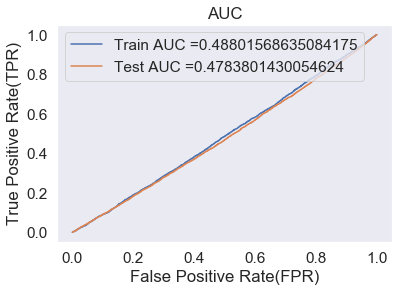

In [127]:
# https://scikitlearn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
Classifier_bow = SGDClassifier(loss = 'hinge', penalty = 'l2', alpha = 1)
Classifier_bow.fit(X_set4_train ,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positiveclass
#https://scikitlearn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier.decision_function
y_train_pred = Classifier_bow.decision_function(X_set4_train)
y_test_pred = Classifier_bow.decision_function(X_set4_test)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.ylabel("True Positive Rate(TPR)")
plt.xlabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

the maximum value of tpr*(1-fpr) 0.25 for threshold 1.0


Text(0.5, 1.0, 'Test Confusion Matix')

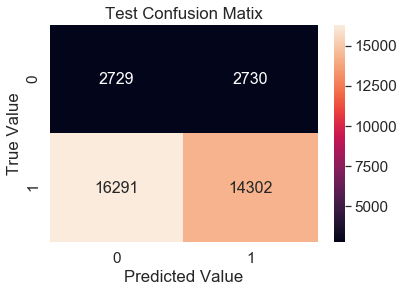

In [128]:
#CONFUSION MATRIX
import seaborn as sea
test_confusion_matrix = pd.DataFrame(confusion_matrix(y_test,predict(y_test_pred,te_thresholds,test_fpr,test_fpr)), range(2),range(2))
sea.set(font_scale=1.4)
sea.heatmap(test_confusion_matrix, annot = True, annot_kws={"size":16}, fmt = 'd')
plt.xlabel("Predicted Value")
plt.ylabel("True Value")
plt.title("Test Confusion Matix")


the maximum value of tpr*(1-fpr) 0.25 for threshold 1.01


Text(0.5, 1.0, 'Train Confusion Matix')

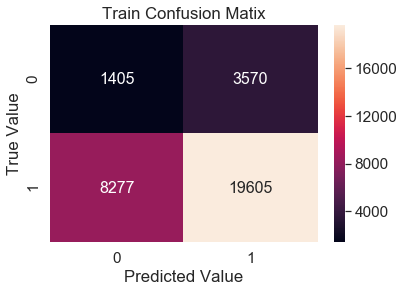

In [94]:
#CONFUSION MATRIX
import seaborn as sea
train_confusion_matrix = pd.DataFrame(confusion_matrix(y_train,predict(y_train_pred,te_thresholds,train_fpr,train_fpr)), range(2),range(2))
sea.set(font_scale=1.4)
sea.heatmap(train_confusion_matrix, annot = True, annot_kws={"size":16}, fmt = 'd')
plt.xlabel("Predicted Value")
plt.ylabel("True Value")
plt.title("Train Confusion Matix")


 Now instead of bow,tf-df ,wordtovec and tfwor2v featurizers i use three new features
1.Sentiment scores of each's essay
2.Number of words in titles
3.Number of words in combined esssays
then after apply logistic regression and by taking best hypermeter then i'll compare my results

# New feature(No. of words in title)

In [95]:
X_cv.shape

(16184, 19)

In [96]:
# For train data
title_length_train=[]
for i in range(0,32857):
  title_length_train.append(len(X_train["project_title"][i].split()))

title_length_train=np.array(title_length_train)

#for test data titles
title_length_test=[]
for i in range(0,36052):
  title_length_test.append(len(X_test["project_title"][i].split()))

title_length_test=np.array(title_length_test)
#for cv data titles
title_length_cv=[]
for i in range(0,16184):
  title_length_cv.append(len(X_cv["project_title"][i].split()))

title_length_cv=np.array(title_length_cv)

# New feature(No. of words in combined essays)

In [97]:
#for test data esssay
essay_length_test=[]
for i in range(0,36052):
  essay_length_test.append(len(X_test["essay"][i].split()))
essay_length_test=np.array(essay_length_test)
#for cv data essay
essay_length_cv=[]
for i in range(0,16184):
  essay_length_cv.append(len(X_cv["essay"][i].split()))
essay_length_cv=np.array(essay_length_cv)
#for train data essay
essay_length_train=[]
for i in range(0,32857):
  essay_length_train.append(len(X_train["essay"][i].split()))
essay_length_train=np.array(essay_length_train)


# New feature(Sentiment scores of each combined essay's)

In [99]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
#https://www.programcreek.com/python/example/100005/nltk.sentiment.vader.SentimentIntensityAnalyzer
def analyze_sentiment(df):
    sentiments = []
    sid = SentimentIntensityAnalyzer()
    for i in tqdm(range(df.shape[0])):
        line = df['essay'][i]  # take one essay
        sentiment = sid.polarity_scores(line)# calculate the sentiment
        sentiments.append([sentiment['neg'], sentiment['pos'],
        sentiment['neu'], sentiment['compound']])# list of lists
    df[['neg', 'pos', 'neu', 'compound']] = pd.DataFrame(sentiments)
    df['Negative'] = df['compound'] < -0.1
    df['Positive'] = df['compound'] > 0.1
    return df

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [100]:
X_train=analyze_sentiment(X_train)
X_test=analyze_sentiment(X_test)
X_cv=analyze_sentiment(X_cv)

100%|███████████████████████████████████████████████████████████████████████████| 16184/16184 [01:49<00:00, 148.45it/s]


# Apply TruncatedSVD on TfidfVectorizer of essay text, choose the number of components ( n_components ) using elbow method :numerical data

In [103]:
#Dimensions are very large so thats why i take less here.
X_train_tf_essay=X_train_tf_essay[:,0:4000]
X_cv_tf_essay=X_cv_tf_essay[:,0:4000]
X_test_tf_essay=X_test_tf_essay[:,0:4000]
from sklearn.decomposition import TruncatedSVD
#https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
#declaring index as Dimensions in train_text_tfidf
Di = [25,50,100,200,500,1500,2000,2500]
Varience_sum = []
for i in tqdm(Di):
    svd = TruncatedSVD(n_components = i, random_state = 42)
    svd.fit(X_train_tf_essay)
    Varience_sum.append(svd.explained_variance_ratio_.sum())



  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

 12%|██████████▌                                                                         | 1/8 [00:02<00:14,  2.02s/it]

 25%|█████████████████████                                                               | 2/8 [00:05<00:14,  2.37s/it]

 38%|███████████████████████████████▌                                                    | 3/8 [00:11<00:17,  3.50s/it]

 50%|██████████████████████████████████████████                                          | 4/8 [00:21<00:22,  5.63s/it]

 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:51<00:38, 12.80s/it]

 75%|███████████████████████████████████████████████████████████████                     | 6/8 [02:41<01:24, 42.11s/it]

 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [05:29<01:19, 79.87s/it]

100%|█████████████████████████

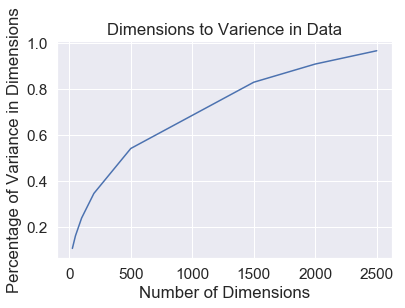

In [104]:
plt.xlabel("Number of Dimensions")
plt.ylabel("Percentage of Variance in Dimensions")
plt.title("Dimensions to Varience in Data")
plt.plot(Di,Varience_sum)
plt.show()


OBSERVATION:
At 2000 dimensions we have Accuracy of greater than 90% so considering 2000 dimensions

In [105]:
svd = TruncatedSVD(n_components= 2000)
svd.fit(X_train_tf_essay)
#Transforms:
#Train SVD
X_train_tf_essay= svd.transform(X_train_tf_essay )
#Test SVD
X_test_tf_essay = svd.transform(X_test_tf_essay )
#CV SVD
X_cv_tf_essay =  svd.transform(X_cv_tf_essay )

# Combine all features:

In [106]:
#for train
pos=list(X_train['pos'])
pos=np.array(pos)
neg=list(X_train['neg'])
neg=np.array(neg)
com=list(X_train['compound'])
com=np.array(com)
# combine all
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_set5_train = hstack((X_train_teacher_prefix,X_train_cat,X_train_subcat,X_train_project_grade_category,X_train_school_state,train_qnty_standar,train_price_standar,train_prev_proj_standar,
                       essay_length_train.reshape(-1,1),title_length_train.reshape(-1,1),
                       pos.reshape(-1,1),neg.reshape(-1,1),com.reshape(-1,1)))


In [107]:
#for test
pos=list(X_test['pos'])
pos=np.array(pos)
neg=list(X_test['neg'])
neg=np.array(neg)
com=list(X_test['compound'])
com=np.array(com)
# combine all
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_set5_test = hstack((X_test_teacher_prefix,X_test_cat,X_test_subcat ,X_test_project_grade_category,X_test_school_state,
                      test_qnty_standar,test_price_standar,test_prev_proj_standar,
                      essay_length_test.reshape(-1,1),title_length_test.reshape(-1,1),
                      pos.reshape(-1,1),neg.reshape(-1,1),com.reshape(-1,1),))

# Applying SVM on SET 5

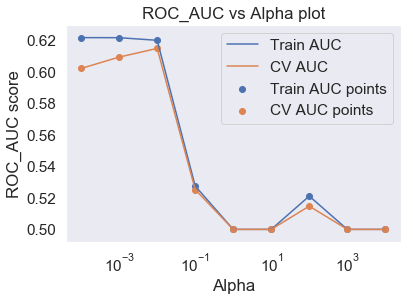

In [108]:
#BY USING L1 RGULARISER
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
#from sklearn.datasets import *
from sklearn import linear_model
from sklearn.linear_model import SGDClassifier
from sklearn import svm
# hyperparameter tuning with l2 reg
""#we are using L1 Regularizer
parameters = {'alpha':[10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}
SV = SGDClassifier(loss = 'hinge', penalty = 'l1', class_weight = 'balanced',)
classifier = GridSearchCV(SV, parameters, cv= 3, scoring='roc_auc',return_train_score=True)
classifier.fit(X_set5_train, y_train)

train_auc= classifier.cv_results_['mean_train_score']
cv_auc = classifier.cv_results_['mean_test_score']

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
plt.plot(parameters['alpha'], cv_auc, label='CV AUC')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')
plt.legend()
plt.xscale("log")
plt.xlabel("Alpha")
plt.ylabel("ROC_AUC score")
plt.title("ROC_AUC vs Alpha plot")
plt.grid()
plt.show()

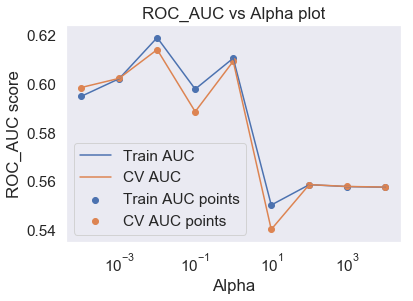

In [109]:
#BY USING L2 REGULARISER

parameters = {'alpha':[10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}
SV = SGDClassifier(loss = 'hinge', penalty = 'l2', class_weight = 'balanced',)
classifier = GridSearchCV(SV, parameters, cv= 3, scoring='roc_auc',return_train_score=True)
classifier.fit(X_set5_train, y_train)

train_auc= classifier.cv_results_['mean_train_score']
cv_auc = classifier.cv_results_['mean_test_score']

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')
plt.legend()
plt.xscale("log")
plt.xlabel("Alpha")
plt.ylabel("ROC_AUC score")
plt.title("ROC_AUC vs Alpha plot")
plt.grid()
plt.show()

Observation:
l2 regularizatiOn works better than l1 and best alpha is 10**3

# Fitting Model to Hyper-Parameter Curve

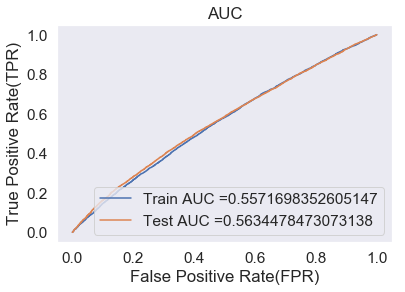

In [121]:
# https://scikitlearn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
Classifier_bow = SGDClassifier(loss = 'hinge', penalty = 'l2', alpha = 10**3)
Classifier_bow.fit(X_set5_train ,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positiveclass
#https://scikitlearn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier.decision_function
y_train_pred = Classifier_bow.decision_function(X_set5_train)
y_test_pred = Classifier_bow.decision_function(X_set5_test)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.ylabel("True Positive Rate(TPR)")
plt.xlabel("False Positive Rate(FPR)") 
plt.title("AUC")
plt.grid()
plt.show()

the maximum value of tpr*(1-fpr) 0.25 for threshold 1.09


Text(0.5, 1.0, 'Test Confusion Matix')

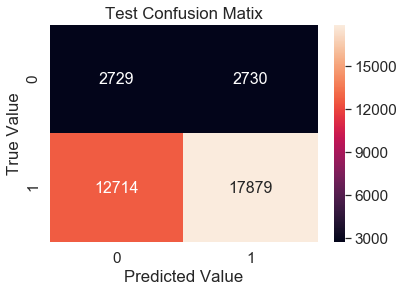

In [112]:
#CONFUSION MATRIX
import seaborn as sea
test_confusion_matrix = pd.DataFrame(confusion_matrix(y_test,predict(y_test_pred,te_thresholds,test_fpr,test_fpr)), range(2),range(2))
sea.set(font_scale=1.4)
sea.heatmap(test_confusion_matrix, annot = True, annot_kws={"size":16}, fmt = 'd')
plt.xlabel("Predicted Value")
plt.ylabel("True Value")
plt.title("Test Confusion Matix")

the maximum value of tpr*(1-fpr) 0.25 for threshold 1.12


Text(0.5, 1.0, 'Train Confusion Matix')

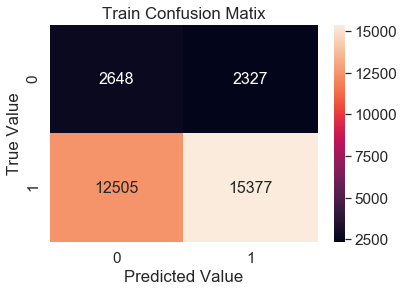

In [113]:
#CONFUSION MATRIX
import seaborn as sea
train_confusion_matrix = pd.DataFrame(confusion_matrix(y_train,predict(y_train_pred,te_thresholds,train_fpr,train_fpr)), range(2),range(2))
sea.set(font_scale=1.4)
sea.heatmap(train_confusion_matrix, annot = True, annot_kws={"size":16}, fmt = 'd')
plt.xlabel("Predicted Value")
plt.ylabel("True Value")
plt.title("Train Confusion Matix")

# Conclusions

In [130]:
# Please compare all your models using Prettytable library
#how to use pretty table http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
tb = PrettyTable()
tb.field_names= ("Vectorizer", " Alpha ", " AUC ")
tb.add_row(["BOW ", 10, 55])
tb.add_row(["Tf - Idf ", 1, 55])
tb.add_row(["AVG - W2V", 1, 48])
tb.add_row(["AVG - Tf - Idf", 1, 47])
tb.add_row(["SVD-Top 2000 Features", 10**3, 56])
print(tb.get_string(titles = "SVM- Observations"))

+-----------------------+---------+-------+
|       Vectorizer      |  Alpha  |  AUC  |
+-----------------------+---------+-------+
|          BOW          |    10   |   55  |
|       Tf - Idf        |    1    |   55  |
|       AVG - W2V       |    1    |   48  |
|     AVG - Tf - Idf    |    1    |   47  |
| SVD-Top 2000 Features |   1000  |   56  |
+-----------------------+---------+-------+
